# CSII 2024 Exercise 11: Nonlinear Control Part 1
&copy; 2024 ETH Zurich, Niclas Scheuer, Dejan Milojevic; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

## Description
This week's Jupyter notebook will cover Feedback Linearization.

In [ ]:
import numpy as np
from sympy import symbols, Matrix, diff, sin, cos, pprint
from sympy.utilities.lambdify import lambdify
from scipy.integrate import solve_ivp, odeint
from scipy.linalg import solve_continuous_are, inv
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%matplotlib inline

## Exercise 1

In this exercise, we will review and recap the formulas associated with feedback linearization and implement them in Python. We will use the below non-linear system:

$ \begin{bmatrix} \dot{x_1} \\ \dot{x_2} \end{bmatrix} = 
\begin{bmatrix} x_2 \\ 2w(1-\mu x_1^2)x_2 -w^2x_1 \end{bmatrix} +
\begin{bmatrix} 0 \\ 1 \end{bmatrix} u $

$ y = x_1$

Where $w, \mu$ are constants that can be assumed $=1$.

### Exercise 1.1
The first step to linearizing the feedback law is to bring the system into the form: 

$\dot{x} = f(x) + g(x)u$

$y=h(x)$

We achieve this by using the [``sympy.Matrix``](https://docs.sympy.org/latest/tutorials/intro-tutorial/matrices.html) definition. In particular, we will use [``lambdify``](https://docs.sympy.org/latest/modules/utilities/lambdify.html) to make them work like functions.

In [ ]:
w=1
mu=1
x1, x2 = symbols('x1 x2')
x = Matrix([x1, x2])

f = Matrix([x2, 2*w*(1-mu*x1**2)*x2 - w**2*x1])
g = 0 #TODO
h = 0 #TODO
f_func = lambdify((x1, x2), f, 'numpy')
g_func = 0 #TODO
h_func = 0 #TODO

### Solution 1.1

In [ ]:
w=1
mu=1
x1, x2 = symbols('x1 x2')
x = Matrix([x1, x2])

# Define the functions
f = Matrix([x2, 2*w*(1-mu*x1**2)*x2 - w**2*x1])
g = Matrix([0, 1])
h = Matrix([x1, 0])
f_func = lambdify((x1, x2), f, 'numpy')
g_func = lambdify((x1, x2), g, 'numpy')
h_func = lambdify((x1, x2), h, 'numpy')

### Exercise 1.2
In order to determine the *relative degree of the system*, we need to use the Lie Derivative $L_f$, $L_g$. This has been implemented below and works as follows:

$L_f h = $ ``lie_derivative(f, h, x)``.

Pay attention to the return types! ``result = lie_derivative(f, h, x)`` produces an object with the following members:
- ``result.matrix``: The matrix representation of the lie derivative. Use this for chained derivatives! Ex: ``lie_derivative(g, result.matrix, x)``
- ``result.func``: A lambdified version of the result. Ex: ``result.func(x1=1, x2=5)``
- ``result.value``: The most relevant output, simply the float or functional value of the lie derivative.

In [ ]:
class LieDerivative:
    def __init__(self, matrix, func, value):
        """Initialize the LieDerivative class."""
        self.matrix = matrix
        self.func = func
        self.value = value

def lie_derivative(vector_field: Matrix, function: Matrix, x: Matrix):
    """Calculate the Lie derivative of a function with respect to a vector field.
    
    Parameters:
    - ``vector_field``: The vector field.
    - ``function``: The function.
    - ``x``: The point at which to evaluate the Lie derivative.

    Returns:
    - ``LieDerivative``: The Lie derivative.
    """
    assert isinstance(function, Matrix), "The function must be a sympy matrix. You likely wanted to do a chained derivative, remember to pass it here as LieDerivative.matrix instead."

    jacobian = function.jacobian(x)
    lie_matrix = jacobian*vector_field

    # Create function form
    lie_func = lambdify(tuple(x), lie_matrix[0], 'numpy')

    # Create value form
    lie_value = lie_matrix[0]
    
    return LieDerivative(lie_matrix, lie_func, lie_value)

Now that the fields $f(x), g(x), h(x)$ and the Lie Derivative are defined, calculate the *relative degree of the system* $\gamma$ using the following rule:

$\gamma$ is the smallest number such that $L_g L_f^{\gamma-1}h \neq 0$

In [ ]:
#TODO: Determine L_g L_f^0 h, check if equal to 0

#TODO: Determine L_g L_f^1 h, check if equal to 0

#TODO: ...

### Solution 1.2

In [ ]:
# Determine L_g L_f^0 h, which is equal to L_g h
lieg_h = lie_derivative(g, h, x)
print("gamma = 1 | L_g L_f^0 h = " + str(lieg_h.value))

# Determine L_g L_f^1 h, which is equal to L_g L_f h
lief_h = lie_derivative(f, h, x)
print(lief_h.value)
lieglief_h = lie_derivative(g, lief_h.matrix, x)
print("gamma = 2 | L_g L_f^1 h = " + str(lieglief_h.value))

# Relative Order of the system: 2
print("Therefore, the relative order of the system is 2.")

### Exercise 1.3
Now that the relative order of the system has been determined, we can make the system behave as the linear system $\frac{d^{\gamma}y}{dt^{\gamma}} = v$ by choosing:

$u = \frac{1}{L_g L_f^{\gamma-1}h(x)} (-L_f^{\gamma}h(x) +v)$

Using the found value of $\gamma$ and the function ``lie_derivative``, calculate u.

In [ ]:
v = symbols('v')
#TODO:
u = 0
print(u)

### Solution 1.3

In [ ]:
v = symbols('v')
lieg_lief_h = lie_derivative(g, lief_h.matrix, x)
print("Value of L_g L_f h = " + str(lieg_lief_h.value))

lief_lief_h = lie_derivative(f, lief_h.matrix, x)
print("Value of L_f L_f h = " + str(lief_lief_h.value))

u = 1/lieg_lief_h.value * (-lief_lief_h.value + v)
print(u)

### Exercise 1.4
Plugging the linearization controller $u(x_1, x_2, v)$ your found above essentially yields the following:

$ \begin{bmatrix} \dot{x_1} \\ \dot{x_2} \end{bmatrix} = 
\begin{bmatrix} x_2 \\ 2w(1-\mu x_1^2)x_2 -w^2x_1 \end{bmatrix} +
\begin{bmatrix} 0 \\ 1 \end{bmatrix} \cdot (-2(1-\mu x_1^2)x_2 + w^2 x_1 + v) $

$ \begin{bmatrix} \dot{x_1} \\ \dot{x_2} \end{bmatrix} = 
\begin{bmatrix} 0 & 1 \\ 0 & 0  \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + 
\begin{bmatrix} 0 \\ 1 \end{bmatrix} v$

$y = \begin{bmatrix} 1 & 0 \end{bmatrix} x$

Therefore, we can now calculate a LQR controller using $A, B, C, D$. Once we find the control law $v = -Kx$, we just need to remember to pass it through $u(x_1, x_2, v)$.

In [ ]:
# Find the LQR gain
# TODO: Define system matrices
A = 0
B = 0
C = 0
D = 0

# Define cost matrices
Q = np.array([[1, 0], [0, 1]])
R = np.array([[1]])

# TODO: Solve continuous ARE
P = 0

# TODO: Compute the LQR gain
K = 0

### Solution 1.5

In [ ]:
A = np.array([[0, 1], [0, 0]])
B = np.array([[0], [1]])
C = np.array([[1, 0]])
D = np.array([[0]])

Q = np.array([[1, 0], [0, 1]])
R = np.array([[1]])

P = solve_continuous_are(A, B, Q, R)

K = np.linalg.inv(R) @ B.T @ P

### Demonstration
The below code demonstrates the effects of using feedback linearization to control a system... and the things that can go wrong without it.

In [ ]:
def control_P(x):
    """This control law lacks any feedback linearization."""
    x_1, x_2 = x
    u = -K @ x
    return u

def control_linearization(x):
    """This control law simply does feedback linearization without LQR control. This means you can put any value of v in, and the system will have that slope."""
    x_1, x_2 = x
    v = 0
    u = -2*(1-x_1**2)*x_2 + x_1 + v
    return u

def control_law(x):
    """This control law includes LQR control and will stabilize the system to the origin."""
    x_1, x_2 = x
    v = -K @ x
    u = -2*(1-x_1**2)*x_2 + x_1 + v
    return u

In [ ]:
def system_dynamics_no_control(t, x):
    x1, x2 = x
    x_dot = f_func(x1, x2)
    return x_dot.reshape(2,)

def system_dynamics_PID(t, x):
    x1, x2 = x
    x_dot = f_func(x1, x2) + g_func(x1, x2)*control_P(x)
    return x_dot.reshape(2,)

def system_dynamics_full(t, x):
    x1, x2 = x
    x_dot = f_func(x1, x2) + g_func(x1, x2)*control_law(x)
    return x_dot.reshape(2,)

def system_dynamics_linearized(t, x):
    x1, x2 = x
    x_dot = f_func(x1, x2) + g_func(x1, x2)*control_linearization(x)
    return x_dot.reshape(2,)

In [ ]:
# Initial conditions
x0 = [0.0, 0.5]

# Time span
t_span = [0, 100]
t_eval = np.linspace(t_span[0], t_span[1], 500)

# Solving the differential equation
solution_no_control = solve_ivp(system_dynamics_no_control, t_span, x0, t_eval=t_eval)
solution_PID = solve_ivp(system_dynamics_PID, t_span, x0, t_eval=t_eval)
solution_linearized = solve_ivp(system_dynamics_linearized, t_span, x0, t_eval=t_eval)
solution_full = solve_ivp(system_dynamics_full, t_span, x0, t_eval=t_eval)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(solution_no_control.t, solution_no_control.y[0], label='No linearization, no controller')
plt.plot(solution_PID.t, solution_PID.y[0], label='No linearization, LQR controller')
plt.plot(solution_linearized.t, solution_linearized.y[1], label='Feedback linearization, no controller')
plt.plot(solution_full.t, solution_full.y[1], label='Feedback linearization, LQR controller')
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System States Over Time')
plt.legend()
plt.grid(True)
plt.show()

Following observations can be made:
- Without a controller, the highly non-linear dynamics of the system can be seen well.
- Naively using the LQR feedback controller _without feedback linearization_ yields bad results. It is not advisable to use linear control theory on nonlinear systems.
- Applying feedback linearization on the system "removes" the non-linear dynamics
- Feedback linearization and LQR provide excellent results.

### BONUS:
What do you think happens if our feedback linearization is "off", i.e. the modelling wasn't perfect? Test the effects of differing the feedback $w, \mu$ from the system $w, \mu$. 

## Exercise 2

In this exercise, we will use feedback linearization to steer a two-link robot gripper as shown below:

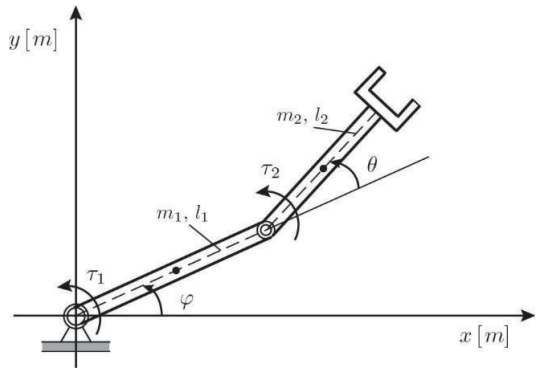

Using the Euler-Lagrange equations, we can derive the dynamic equations of motion for the gripper: 

$M(\dot{q}, \ddot{q}) + C(\dot{q}) + G = \tau$

$Y = q$

In [ ]:
m1, m2 = 1, 1 #kg
l1, l2 = 1, 1 #m
g = 9.81 #m/s^2

q1, q2, q1dot, q2dot = symbols('q1 q2 q1dot q2dot')
q = Matrix([q1, q2, q1dot, q2dot])
u1, u2 = symbols('u1 u2')

M11 = 1/3*m1*l1**2 + 1/3*m2*l2**2 + m2*l1**2 + m2*l1*l2*cos(q2)
M12 = M21 = 1/3*m2*l2**2 + 1/2*m2*l1*l2*cos(q2)
M22 = 1/3*m2*l2**2
M = Matrix([[M11, M12], [M21, M22]])
M_func = lambdify((q1, q2, q1dot, q2dot), M, 'numpy')

C11 = -1/2*m2*l1*l2*q2dot*sin(q2)
C12 = -1/2*m2*l1*l2*sin(q2)*(q1dot + q2dot)
C21 = -1/2*m2*l1*l2*q1dot*sin(q2)
C22 = 0
C = Matrix([[C11, C12], [C21, C22]])*Matrix([[q1dot], [q2dot]])
C_func = lambdify((q1, q2, q1dot, q2dot), C, 'numpy')

G1 = (1/2*m1*l1 + m2*l1)*g*cos(q1) + 1/2*m2*l2*g*cos(q1 + q2)
G2 = 1/2*m2*l2*g*cos(q1 + q2)
G = Matrix([[G1], [G2]])
G_func = lambdify((q1, q2, q1dot, q2dot), G, 'numpy')

Partially rearranged:

$ \begin{bmatrix} q_1 \\ q_2 \\ \dot{q_1} \\ \dot{q_2} \end{bmatrix}' =
\begin{bmatrix}
\begin{matrix}
0 & 0 \\
0 & 0 
\end{matrix} & \begin{matrix}
1 & 0 \\
0 & 1 
\end{matrix} \\
\begin{matrix}
0 & 0 \\
0 & 0 
\end{matrix} & -\begin{bmatrix}M_{11} & M_{12} \\ M_{21} & M_{22}\end{bmatrix}^{-1} \begin{bmatrix}C_{11} & C_{12} \\ C_{21} & C_{22}\end{bmatrix} 
\end{bmatrix} 
\begin{bmatrix} q_1 \\ q_2 \\ \dot{q_1} \\ \dot{q_2} \end{bmatrix} - \begin{bmatrix} 0 \\ 0 \\ G_1 \\ G_2 \end{bmatrix}+ \begin{bmatrix} 0 \\ 0 \\ \tau_1 \\ \tau_2 \end{bmatrix} $

### Exercise 2.1
Finish bringing the equation into the form: 

$\dot{x} = f(x) + g_1(x) \tau_1 + g_2(x) \tau_2$

$y = \begin{bmatrix} h_1(x) \\ h_2(x) \end{bmatrix} = \begin{bmatrix} q_1 \\ q_2 \end{bmatrix} $

Determine and program $f(x), g_1(x), g_2(x), h_1(x), h_2(x)$.

In [ ]:
matrix_cal = Matrix([[M11, M12], [M21, M22]]).inv() * Matrix([[C11*q1dot, C12*q2dot], [C21*q1dot, C22*q2dot]])

f_row1 = q1dot
f_row2 = q2dot
f_row3 = matrix_cal[0] - G1
f_row4 = matrix_cal[1] - G2
f = 0 #TODO
f_func = lambdify(0, 0, 'numpy') #TODO

g_1 = 0 #TODO
g_2 = 0 #TODO

h_1 = 0 #TODO
h_2 = 0 #TODO

### Solution 2.1

In [ ]:
matrix_cal = Matrix([[M11, M12], [M21, M22]]).inv() * Matrix([[C11*q1dot, C12*q2dot], [C21*q1dot, C22*q2dot]])

f_row1 = q1dot
f_row2 = q2dot
f_row3 = matrix_cal[0] - G1
f_row4 = matrix_cal[1] - G2
f = Matrix([f_row1, f_row2, f_row3, f_row4])
f_func = lambdify((q1, q2, q1dot, q2dot), f, 'numpy')

g_1 = Matrix([0, 0, 1, 0])
g_2 = Matrix([0, 0, 0, 1])

h_1 = Matrix([q1, 0, 0, 0])
h_2 = Matrix([0, q2, 0, 0])

### Exercise 2.2
From "EN530.678 Nonlinear Control and Planning in Robotics, Lecture 8: Feedback Linearization" we find the formula for determining the _relative degree of a MIMO system_.

$y_1^{\gamma_1} = L_f^{\gamma_1} h_1 + L_{g_1} L_f^{\gamma_1 -1} h_1 u_1 + L_{g_2} L_f^{\gamma_1 -1} h_1 u_2$

$y_2^{\gamma_2} = L_f^{\gamma_2} h_2 + L_{g_1} L_f^{\gamma_2 -1} h_2 u_1 + L_{g_2} L_f^{\gamma_2 -1} h_2 u_2$

Since this is a long task, simply determine the smallest $\gamma_1$ such that $y_1^{\gamma_1}$ is dependent on either $u_1$ or $u_2$. It turns out $\gamma_1 = \gamma_2$.

Use this implementation of the function ``lie_derivative``:

In [ ]:
# Find y_1^1
y_1_1 = ... + ... + ...
print(y_1_1)

# Find y_1^2
y_1_2 = ... + ... + ...
print(y_1_2)

# ...

### Solution 2.2

In [ ]:
# y_1, gamma_1 = 1
y_1_1 = lie_derivative(f, h_1, q).value + lie_derivative(g_1, h_1, q).value*u1 + lie_derivative(g_2, h_1, q).value*u2
print("gamma_1 = 1 | L_f^1 h_1 + L_g_1 h_1 u_1 + L_g_2 h_1 u_2 = " + str(y_1_1))
# y_1, gamma_1 = 2
lief_h_1 = lie_derivative(f, h_1, q)
print(lief_h_1.value)
y_1_2 = lie_derivative(f, lief_h_1.matrix, q).value + lie_derivative(g_1, lief_h_1.matrix, q).value*u1 + lie_derivative(g_2, lief_h_1.matrix, q).value*u2
print("gamma_1 = 2 | L_f^2 h_1 + L_g_1 L_f h_1 u_1 + L_g_2 L_f h_1 u_2 = " + str(y_1_2))

print("Therefore, the relative order of the system is 2.")

### Exercise 2.3
Given that we found the needed relative order of the system (2), we can now build a feedback linearizing controller.
The second derivative of $Y$ is given by the following formula:

$\ddot{Y} = \ddot{q} = M(\dot{q}, \ddot{q})^{-1}(-C(\dot{q}) -G+\tau) = v$

Rearranging:

$\tau = M(\dot{q}, \ddot{q})v + C(\dot{q}) + G$

In the below cell, finish building a simple PD controller.

In [ ]:
def control_pd(q: np.ndarray, q_des: np.ndarray, K_p: float, K_d: float) -> np.ndarray:
    q1, q2, q1dot, q2dot = q
    q1_desired, q2_desired = q_des
    # Position Error
    # TODO
    # Velocity Error
    # TODO
    return 0

### Solution 2.3

In [ ]:
def control_pd(q: np.ndarray, q_des: np.ndarray, K_p: float, K_d: float) -> np.ndarray:
    q1, q2, q1dot, q2dot = q
    q1_desired, q2_desired = q_des
    # Position Error
    e_q = K_p*np.array([[q1_desired - q1], [q2_desired - q2]])
    # Velocity Error
    e_qdot = K_d*np.array([[0 - q1dot], [0 - q2dot]])
    return e_q + e_qdot

### Demonstration
Finally, set your intended joint positions and controller gains below and watch the robot arm go!

In [ ]:
q1_desired = 0.0
q2_desired = np.pi/2
K_p = 1
K_d = 1

In [ ]:
def control_linearization(v, q):
    """This control law simply does feedback linearization without LQR control. This means you can put any value of v in, and the system will have that slope."""
    q1, q2, q1dot, q2dot = q
    M = M_func(q1, q2, q1dot, q2dot)
    C = C_func(q1, q2, q1dot, q2dot)
    G = G_func(q1, q2, q1dot, q2dot)
    tau = M@v + C + G
    return np.vstack((np.zeros((2,1)), tau))

def system_dynamics_full(t, q):
    q1, q2, q1dot, q2dot = q
    v = control_pd(q, [q1_desired, q2_desired], K_p, K_d)
    q_dot = f_func(q1, q2, q1dot, q2dot) + control_linearization(v, q)
    return q_dot.flatten()

# Initial conditions
q0 = [0.5, 0.5, 0.0, 0.0]

# Time span
t_span = [0, 100]
t_eval = np.linspace(t_span[0], t_span[1], 500)

# Solving the differential equation
solution = solve_ivp(system_dynamics_full, t_span, q0, t_eval=t_eval)
# Plotting the results
plt.figure(figsize=(10, 5))

plt.axhline(y=q1_desired, color='b', linestyle=':', label='Reference 1')
plt.axhline(y=q2_desired, color='orange', linestyle=':', label='Reference 2')

plt.plot(solution.t, solution.y[0], label='Joint Position 1')
plt.plot(solution.t, solution.y[1], label='Joint Position 2')
plt.plot(solution.t, solution.y[2], label='Joint Velocity 1')
plt.plot(solution.t, solution.y[3], label='Joint Velocity 2')

plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System States Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def compute_positions(solution):
    num_time_steps = len(solution.t)
    x = np.zeros((num_time_steps, 3))  # x coordinates of the base, joint 1, and end effector
    y = np.zeros((num_time_steps, 3))  # y coordinates of the base, joint 1, and end effector

    for i in range(num_time_steps):
        q1 = solution.y[0, i]
        q2 = solution.y[1, i]
        x[i, 1] = l1 * np.cos(q1)  # x position of joint 1
        y[i, 1] = l1 * np.sin(q1)  # y position of joint 1
        x[i, 2] = x[i, 1] + l2 * np.cos(q1 + q2)  # x position of end effector
        y[i, 2] = y[i, 1] + l2 * np.sin(q1 + q2)  # y position of end effector

    return x, y

x, y = compute_positions(solution)

# Plot the robot arm movement
fig, ax = plt.subplots()
ax.set_xlim(-l1-l2-0.5, l1+l2+0.5)
ax.set_ylim(-l1-l2-0.5, l1+l2+0.5)
ax.set_aspect('equal')
line, = ax.plot([], [], 'o-', lw=2)

def init():
    line.set_data([], [])
    return line,

def update(frame):
    line.set_data(x[frame, :], y[frame, :])
    return line,

ani = FuncAnimation(fig, update, frames=range(500), init_func=init, blit=True, interval=100)

# Display animation in Jupyter notebook
HTML(ani.to_jshtml())